## Getting news


In [2]:
%load_ext autoreload
%autoreload 2
from mongoengine import connect
from tweepyrate import create_apps
from hate_collector.models import Tweet

client = connect("hatespeech-news")
db = client["hatespeech-news"]

screen_names = [t[1:].lower() for t in db.tweet.distinct('query') if t is not None]
screen_names

['lanacion',
 'prensarepublica',
 'abc_es',
 'clarincom',
 'cronica',
 'elmundoes',
 'elpaisuy',
 'infobae',
 'laderechadiario',
 'latercera',
 'lavanguardia',
 'perfilcom']

In [3]:
tweets_and_replies = db.tweet.aggregate([ 
    {
        "$match": {
            "user_name": {"$in": screen_names },
            "possibly_hateful_comments": True
        }
    },
    { 
        "$lookup": {   
            "from": "tweet",   
            "localField": "_id",   
            "foreignField": "in_reply_to_status_id", 
            "as": "replies"
        }
    },
])

tweets_and_replies = list(tweets_and_replies)

In [7]:
from tqdm.notebook import tqdm
from newspaper import Article, ArticleException

for tweet in tqdm(tweets_and_replies):
    try:
        if "article" in tweet:
            continue
        news_url = tweet["entities"]["urls"][0]["expanded_url"]
        article = Article(news_url)
        article.download()
        article.parse()
        tweet["article"] = article
    except (KeyError, IndexError) as e:
        pass
    except ArticleException as e:
        pass

In [13]:
with_articles = len([1 for t in tweets_and_replies if tweet["article"]])

print(f"There are {with_articles / len(tweets_and_replies)*100:.2f}% of tweets with their articles")

There are 100.00% of tweets with their articles


In [24]:
art = tweets_and_replies[-100]["article"]

In [25]:
art.parse()

In [65]:
empty_arts = [t for t in tweets_and_replies if "article" in t and t["article"].text == '']
non_empty_arts = [t for t in tweets_and_replies if "article" in t and t["article"].text != '']

In [66]:
len(empty_arts), len(non_empty_arts)

(159, 2345)

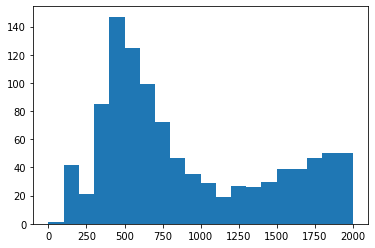

In [76]:
import matplotlib.pyplot as plt

plt.hist([len(art["article"].text) for art in non_empty_arts], range=[0, 2000], bins=20);

In [77]:
la_tercera_art = empty_arts[-11]

It seems we have a problem with "La Tercera". 

In [78]:
url = "https://www.latercera.com/politica/noticia/quintana-y-flores-convocan-a-firmantes-del-acuerdo-por-la-paz-y-la-nueva-constitucion-para-comprometer-un-plebiscito-democratico-y-pacifico/3TANLW5XCZDB7FWZZNOHDSSUQQ/"

art = Article(url)
art.download()
art.parse()

art.text

''

In [79]:
la_tercera_art["entities"]["urls"][0]["expanded_url"]

'http://bit.ly/2xhG0mW'

In [80]:
from collections import Counter

Counter([t["user"]["screen_name"] for t in empty_arts])

Counter({'abc_es': 1,
         'elmundoes': 5,
         'infobae': 9,
         'laderechadiario': 1,
         'LANACION': 3,
         'latercera': 139,
         'LaVanguardia': 1})

In [92]:
def get_article_representation(tweet):
    ret = {
        "id": tweet["_id"],
        "tweet": tweet["text"],
        "body": tweet["article"].text,
        "replies": []
    }
    
    
    for reply in tweet["replies"]:
        ret["replies"].append({
            "id": reply["_id"],
            "text": reply["text"],
        })
    
    return ret


In [93]:
articles_and_comments = [get_article_representation(tweet) for tweet in non_empty_arts]

In [94]:
len(articles_and_comments)

2345

In [96]:
len([1 for tweet in articles_and_comments for reply in tweet["replies"]])

166940

In [27]:
def show_tweet(tweet):
    print(f"Tweet id: {tweet['_id']}")
    print(f"Interesting? {tweet['interesting']}")
    print(f"Checked ? {tweet['checked']}")
    print(tweet["created_at"], "\n\n")
    
    
    print(f"@{tweet['user']['screen_name']}")
    print(tweet["text"])
    
    print("\nRespuestas:")
    
    for j, reply in enumerate(tweet["replies"]):
        if j > 60:
            break
        print(f"{reply['_id']:<14} -- {j+1:<3}- {reply['text']}")
        
for i, tw in enumerate(errors):
    print('\n' + ("="*80 + '\n') * 4) 
    print(f"Número {i+1}\n")
    show_tweet(tw)



Número 1

Tweet id: 1228345565085302784
Interesting? False
Checked ? False
2020-02-14 15:49:38 


@clarincom
AHORA: dictan la prisión preventiva para los ocho rugbiers acusados de asesinar a Fernando Báez Sosa. https://t.co/sdLeqdqVFX

Respuestas:
1228345921697648641 -- 1  - @clarincom Cuanto pagaron las familias y la mama kirchnerista del principal asesino???
1228346199838744576 -- 2  - @clarincom A estos los meten en cana... y la yegua malparida que mató a un fiscal todavía sigue libre.
1228346809531191298 -- 3  - @clarincom Era lo lógico y esperable!!!
1228347080160223233 -- 4  - @clarincom Premeditación y alevosia!!👏👏👏
1228347250931359747 -- 5  - @clarincom Excelente noticia!
1228357573318934530 -- 6  - @clarincom Tan dificil es mirar en las redes sociales de los asesinos para ver quien era pipo?
1228357765946585090 -- 7  - @clarincom Y los que están pasando las vacaciones en Zárate ??? No tienen culpa ??? Acaso ellos que hicieron para no permitir que el grupo hiciera lo que hici